# Price American Option under Heston Model

## Explicit Scheme for Heston Model

### Parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from math import isclose

# Parameters
r = 0.05
kappa = 1.0
theta = 0.2
eta = 0.5
rho = -0.4
s0 = 100.0
v0 = 0.25
T = 1.0
K = 100.0

# Numerical solution parameters
# smin and vmin are always fixed as 0.0
smax = 200.0
vmax = 1.0

### Price put option in Heston model, set up terminal condition

In [2]:
# Return a matrix as the terminal condition at time T
# Has to know ds and dv for the size of the matrix
def set_put_payoff(smax,ds,vmax,dv,K):
    N = int(np.round(smax / ds))
    J = int(np.round(vmax / dv))
    stk_price = np.linspace(0.0,smax,N + 1)
    terminal_vec = np.maximum(K - stk_price,0)
    # Broadcast the vector to a matrix
    terminal_mat = np.tile(np.reshape(terminal_vec,(N + 1,1)),(1,J + 1))
    return terminal_mat

### Set up coefficients in explicit finite difference scheme

In [3]:
# Input n,j and output a_{n;j}
def set_a_FD(n,j,dt,dv,r,eta,theta,kappa,rho):
    return 1 - (dt / dv) * (r * dv + (n ** 2) * j * (dv ** 2) + (eta ** 2) * j)

# Input n,j and output b_{n;j}
def set_b_FD(n,j,dt,dv,r,eta,theta,kappa,rho):
    return (dt / 2) * ((n * r) + (n ** 2) * j * dv)
    
# Input n,j and output c_{n;j}
def set_c_FD(n,j,dt,dv,r,eta,theta,kappa,rho):
    return (dt / 2) * (-(n * r) + (n ** 2) * j * dv)

# Input n,j and output d_{n;j}
def set_d_FD(n,j,dt,dv,r,eta,theta,kappa,rho):
    return (dt / (2 * dv)) * ( kappa * (theta - j * dv) + (eta ** 2) * j)

# Input n,j and output e_{n;j}
def set_e_FD(n,j,dt,dv,r,eta,theta,kappa,rho):
    return (dt / (2 * dv)) * (-kappa * (theta - j * dv) + (eta ** 2) * j)

# Input n,j and output f_{n;j}
def set_f_FD(n,j,dt,dv,r,eta,theta,kappa,rho):
    return (dt * eta * j * n * rho) / 4

### Implement explicit finite difference

In [4]:
# American style put option pricing through explicit FD.
# The last parameter indicates the early exercise frequency, 
# it can take non-negative values or "None".
# If it takes "None", early exercise is not permitted so it's a European option.
# If it takes 0, it's an American option.
# If it takes strictly positive values, it's a Bermudan option.
def explicit_FD_Heston(dt,ds,dv,T,smax,vmax,r,kappa,theta,eta,rho,K,freq):
    # Get size of matrix (tmin = 0.0)
    tmax = T
    M = int(np.round(tmax / dt))
    N = int(np.round(smax / ds))
    J = int(np.round(vmax / dv))
    
    # Only maintain two matrices of size (N + 1) * (J + 1) to record the 
    # numerical solution at all space variables
    # at the current time and the last time
    last_sol = set_put_payoff(smax,ds,vmax,dv,K)
    sol = last_sol.copy()
    
    for m in range(M,0,-1):
        # Time index is m so derive C^{m-1} based on C^m
        # We have to derive C^{m-1}_{n;j} for all possible (n,j)
        
        # The first thing to do is to record the solution at the last time in last_sol
        # and we only update sol
        last_sol = sol
        
        for n in range(N,-1,-1):
            for j in range(J,-1,-1):
                
                # Check whether it hits boundary (put boundary condition)
                if n == 0:
                    sol[n,j] = sol[n + 1,j] + ds
                    continue
                if n == N:
                    sol[n,j] = 0
                    continue
                if j == 0:
                    sol[n,j] = (1 - r * dt) * last_sol[n,0]
                    continue
                if j == J:
                    sol[n,j] = K * np.exp(-r * (T - m * dt))
                    continue
                
                # Otherwise, get all coefficients
                a_FD = set_a_FD(n,j,dt,dv,r,eta,theta,kappa,rho)
                b_FD = set_b_FD(n,j,dt,dv,r,eta,theta,kappa,rho)
                c_FD = set_c_FD(n,j,dt,dv,r,eta,theta,kappa,rho)
                d_FD = set_d_FD(n,j,dt,dv,r,eta,theta,kappa,rho)
                e_FD = set_e_FD(n,j,dt,dv,r,eta,theta,kappa,rho)
                f_FD = set_f_FD(n,j,dt,dv,r,eta,theta,kappa,rho)
                
                # Perform update (continuation value)
                sol[n,j] = a_FD * last_sol[n,j] + b_FD * last_sol[n + 1,j] + \
                c_FD * last_sol[n - 1,j]\
                + d_FD * last_sol[n,j + 1] + e_FD * last_sol[n,j - 1]\
                + f_FD * (last_sol[n + 1,j + 1] + last_sol[n - 1,j - 1] - \
                          last_sol[n + 1,j - 1] - last_sol[n - 1,j + 1])
                
                # Take pointwise maximum with immediate exercise payoff
                # Check if early exercise is permitted at this time step
                early_exer = False
                if freq is not None:
                    if isclose(freq,0.0):
                        early_exer = True
                    else:
                        current_time = m * dt
                        quotient = np.round(current_time / freq)
                        # If the early exercise time is the closest to the 
                        # current time discretization step
                        if quotient * freq >= (m - 0.5) * dt and \
                        quotient * freq <= (m + 0.5) * dt:
                            early_exer = True
                    
                # If early exercise is possible, update the value
                if early_exer:
                    immed_payoff = np.maximum(K - n * ds,0)
                    
                    # Force the value to be larger
                    sol[n,j] = np.maximum(sol[n,j],immed_payoff)
                    
    return sol

### Call the function for European put

In [5]:
# Set ds,dv,dt
dt = 1e-4
ds = 5
dv = 0.05

# Take out the option price at s0 and v0
s_ind = int(np.round(s0 / ds))
v_ind = int(np.round(v0 / dv))

# Test European put
freq = None
sol = explicit_FD_Heston(dt,ds,dv,T,smax,vmax,
                        r,kappa,theta,eta,rho,K,freq)
put_price = sol[s_ind,v_ind]
print('European put price: ' + str(put_price))

European put price: 15.710308129450906


### Plot option price surface for American option

American put price: 16.242038875961637


<Figure size 432x288 with 0 Axes>

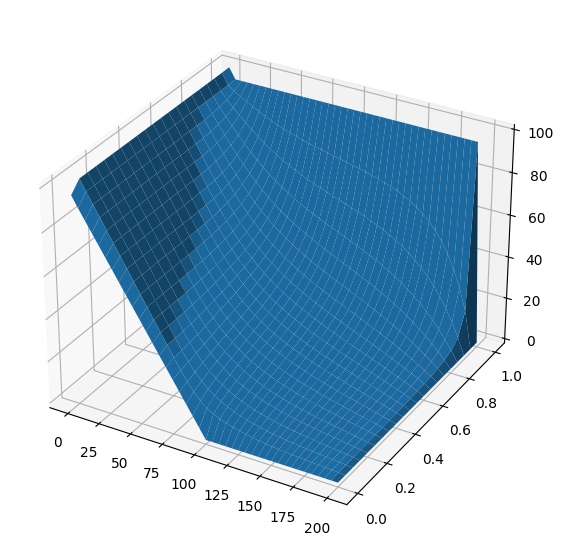

In [6]:
# American put
dt = 1e-4
ds = 5
dv = 0.05
freq = 0.0
sol = explicit_FD_Heston(dt,ds,dv,T,smax,vmax,
                        r,kappa,theta,eta,rho,K,freq)
put_price = sol[s_ind,v_ind]
print('American put price: ' + str(put_price))

# Make surface plot
M = int(np.round(T / dt))
N = int(np.round(smax / ds))
J = int(np.round(vmax / dv))
plot_S = np.linspace(0.0,smax,N + 1)
plot_V = np.linspace(0.0,vmax,J + 1)
plot_S, plot_V = np.meshgrid(plot_S, plot_V)
fig = plt.figure()
fig = plt.figure(figsize=(11,7), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')

# Plot call price
ax.plot_surface(plot_S,plot_V,sol.transpose())

### Bermudan option pricing

In [7]:
# Set ds,dv,dt
# Make sure that 1/dt is a multiple of 24 and 365, so it's fair comparison
dt = 1e-4
ds = 5
dv = 0.05

# A list of exercise frequency
freq_list = [1/6,1/12,1/24,1/365]

# Bermudan put
for freq in freq_list:
    sol = explicit_FD_Heston(dt,ds,dv,T,smax,vmax,
                        r,kappa,theta,eta,rho,K,freq)
    Bermudan_price = sol[s_ind,v_ind]
    print('When exercise frequency is: ' + str(freq) +  
          ', Bermudan option price is: ' + str(Bermudan_price))

When exercise frequency is: 0.16666666666666666, Bermudan option price is: 16.142252567649805
When exercise frequency is: 0.08333333333333333, Bermudan option price is: 16.191647422526678
When exercise frequency is: 0.041666666666666664, Bermudan option price is: 16.217213198073733
When exercise frequency is: 0.0027397260273972603, Bermudan option price is: 16.24061829714642


## Two-dimensional GBM Model, explicit FD scheme

### Parameters

In [8]:
%reset -f

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math
from math import isclose
import scipy
from scipy.stats import norm

# Parameters
r = 0.06
sigma1 = 0.2
sigma2 = 0.2
T = 1.0
freq = 0.04
s1_init = 40.0
s2_init = 40.0
d = 0.02
K = 40.0

# Numerical solution parameters
# smin and vmin are always fixed as 0.0
s1_max = 120.0
s2_max = 120.0

### Black-Scholes formula for European put with dividend payment

In [10]:
# BS formula for put price with dividend yield d
def BS_put(s0,K,r,sigma,T,d):
    # Deal with the case where T = 0
    if isclose(T,0.0):
        put_price = np.maximum(K - s0,0)
        return put_price
    
    # Deal with the case where stock price is zero
    s0 = s0 + 1e-4
    d1 = (np.log(s0 / K) + (r - d + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - s0 * np.exp(-d * T) * norm.cdf(-d1)
    return put_price

The single European put price is: 2.3540067535299514


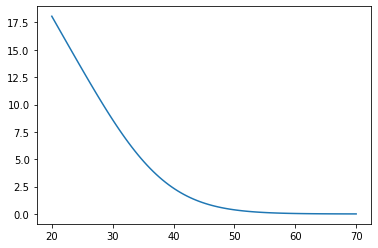

In [11]:
# Plot the relationship between put price and initial stock price
# to test the BS formula
stk_price = np.linspace(20,70,100)
put_price = BS_put(stk_price,K,r,sigma1,T,d)
print('The single European put price is: ' + str(BS_put(s1_init,K,r,sigma1,T,d)))
plt.plot(stk_price,put_price)

### Set payoff

In [12]:
# Return a matrix as the terminal condition at time T
# Has to know ds1 and ds2 for the size of the matrix
def set_avg_put_payoff(s1_max,ds1,s2_max,ds2,K):
    N = int(np.round(s1_max / ds1))
    J = int(np.round(s2_max / ds2))
    stk1_price = np.linspace(0.0,s1_max,N + 1)
    stk2_price = np.linspace(0.0,s2_max,J + 1)
    grid_1, grid_2 = np.meshgrid(stk2_price,stk1_price)
    
    # Calculate average price at each grid point
    grid_avg_price = (grid_1 + grid_2) / 2
    terminal_mat = np.maximum(K - grid_avg_price,0)
    return terminal_mat

### Coefficients in explicit FD scheme

In [13]:
# Input n,j and output a_{n;j}
def set_a_FD(n,j,dt,r,sigma1,sigma2,d):
    return 1 - dt * (r + (n ** 2) * (sigma1 ** 2) + (j ** 2) * (sigma2 ** 2))

# Input n,j and output b_{n;j}
def set_b_FD(n,j,dt,r,sigma1,sigma2,d):
    return (dt / 2) * (n * (r - d) + (n ** 2) * (sigma1 ** 2))
    
# Input n,j and output c_{n;j}
def set_c_FD(n,j,dt,r,sigma1,sigma2,d):
    return (dt / 2) * (-n * (r - d) + (n ** 2) * (sigma1 ** 2))

# Input n,j and output d_{n;j}
def set_d_FD(n,j,dt,r,sigma1,sigma2,d):
    return (dt / 2) * (j * (r - d) + (j ** 2) * (sigma2 ** 2))

# Input n,j and output e_{n;j}
def set_e_FD(n,j,dt,r,sigma1,sigma2,d):
    return (dt / 2) * (-j * (r - d) + (j ** 2) * (sigma2 ** 2))

### Explicit FD Scheme

In [14]:
# American style put option pricing through explicit FD.
# The last parameter indicates the early exercise frequency, 
# it can take non-negative values or "None".
# If it takes "None", early exercise is not permitted so it's a European option.
# If it takes 0, it's an American option.
# If it takes strictly positive values, it's a Bermudan option.
def explicit_FD_2dim_GBM(dt,ds1,ds2,T,s1_max,s2_max,r,sigma1,sigma2,d,K,freq):
    # Get size of matrix (tmin = 0.0)
    tmax = T
    M = int(np.round(tmax / dt))
    N = int(np.round(s1_max / ds1))
    J = int(np.round(s2_max / ds2))
    
    # Only maintain two matrices of size (N + 1) * (J + 1) to record the 
    # numerical solution at all space variables
    # at the current time and the last time
    last_sol = set_avg_put_payoff(s1_max,ds1,s2_max,ds2,K)
    sol = last_sol.copy()
    
    for m in range(M,0,-1):
        # Time index is m so derive C^{m-1} based on C^m
        # We have to derive C^{m-1}_{n;j} for all possible (n,j)
        
        # The first thing to do is to record the solution at the last time in last_sol
        # and we only update sol
        last_sol = sol
        
        # Set boundary conditions
        for j in range(0,J + 1):
            sol[0,j] = BS_put((j * ds2) / 2,K,r,sigma2,T - m * dt,d)
        for j in range(0,J + 1):
            sol[N,j] = 0
        for n in range(0,N + 1):
            sol[n,0] = BS_put((n * ds1) / 2,K,r,sigma1,T - m * dt,d)
        for n in range(0,N + 1):
            sol[n,J] = 0
        
        # Non-corner case
        for n in range(N - 1,0,-1):
            for j in range(J - 1,0,-1):
                
                # Get all coefficients
                a_FD = set_a_FD(n,j,dt,r,sigma1,sigma2,d)
                b_FD = set_b_FD(n,j,dt,r,sigma1,sigma2,d)
                c_FD = set_c_FD(n,j,dt,r,sigma1,sigma2,d)
                d_FD = set_d_FD(n,j,dt,r,sigma1,sigma2,d)
                e_FD = set_e_FD(n,j,dt,r,sigma1,sigma2,d)
                
                # Perform update (continuation value)
                sol[n,j] = a_FD * last_sol[n,j] + b_FD * last_sol[n + 1,j] + \
                c_FD * last_sol[n - 1,j]\
                + d_FD * last_sol[n,j + 1] + e_FD * last_sol[n,j - 1]
                
                # Take pointwise maximum with immediate exercise payoff
                # Check if early exercise is permitted at this time step
                early_exer = False
                if freq is not None:
                    if isclose(freq,0.0):
                        early_exer = True
                    else:
                        current_time = m * dt
                        quotient = np.round(current_time / freq)
                        # If the early exercise time is the closest to the 
                        # current time discretization step
                        if quotient * freq >= (m - 0.5) * dt and \
                        quotient * freq <= (m + 0.5) * dt:
                            early_exer = True
                    
                # If early exercise is possible, update the value
                if early_exer:
                    immed_payoff = np.maximum(K - ((n * ds1 + j * ds2) / 2),0)
                    
                    # Force the value to be larger
                    sol[n,j] = np.maximum(sol[n,j],immed_payoff)
                    
    return sol

### Test for European Average Put

European average put price: 1.4859956724708387


<Figure size 432x288 with 0 Axes>

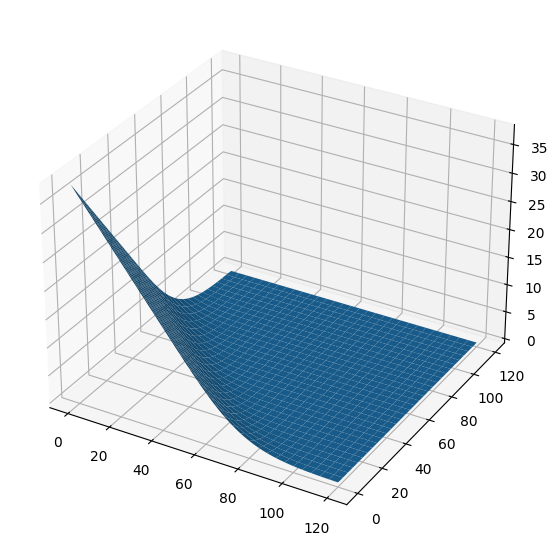

In [15]:
# European average put
dt = 1e-4
ds1 = 2
ds2 = 2
freq = None
sol = explicit_FD_2dim_GBM(dt,ds1,ds2,T,s1_max,s2_max,
                           r,sigma1,sigma2,d,K,freq)

# Take out the option price at s0 and v0
s1_ind = int(np.round(s1_init / ds1))
s2_ind = int(np.round(s2_init / ds2))

put_price = sol[s1_ind,s2_ind]
print('European average put price: ' + str(put_price))

# Make surface plot
M = int(np.round(T / dt))
N = int(np.round(s1_max / ds1))
J = int(np.round(s2_max / ds2))
plot_S1 = np.linspace(0.0,s1_max,N + 1)
plot_S2 = np.linspace(0.0,s2_max,J + 1)
plot_S1, plot_S2 = np.meshgrid(plot_S1, plot_S2)
fig = plt.figure()
fig = plt.figure(figsize=(11,7), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')

# Plot call price
ax.plot_surface(plot_S1,plot_S2,sol.transpose())

### Bermudan Average Put

In [16]:
# Bermudan average put
dt = 1e-4
ds1 = 2
ds2 = 2
freq = 0.04
sol = explicit_FD_2dim_GBM(dt,ds1,ds2,T,s1_max,s2_max,
                           r,sigma1,sigma2,d,K,freq)

put_price = sol[s1_ind,s2_ind]
print('Bermudan average put price: ' + str(put_price))

Bermudan average put price: 1.6514431322961094
